# KNN
## -> without removing stopwords, with stemming
- Accuracy: around 0.86 for k=20 (up to 0.87 for k = 50)
- F1-value:
- Roc-curve:

In [1]:
import pandas as pd
df = pd.read_csv('dataset.csv')
#df = df.sample(120000)
df_target = df['humor']
df_data = df.copy()
df_data.drop(columns='humor')

df_target.head()

0    False
1    False
2     True
3    False
4    False
Name: humor, dtype: bool

Preprocessing

In [2]:
from sklearn import preprocessing

#encode target to numeric
label_encoder = preprocessing.LabelEncoder()
df_target = label_encoder.fit_transform(df_target)
#df_target

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

#Apply CountVectorizer on text column

vectorizer = CountVectorizer(binary=True)

#If this vectorizer is used, a word which occurs multiple times is counted and not just displayed as 1 = word occurs 
#cVectorizer = CountVectorizer(binary=False)

#At the moment I am not able to apply the vectorizer on the whole dataset. To many records & less available RAM
matrix = vectorizer.fit_transform(df_data['text'].head(15))

print("Vectorizer created {} features.".format(len(vectorizer.get_feature_names())))

df_data_countVectorized = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
#display(df_data_countVectorized)

Vectorizer created 131 features.


C:\Users\mcl.NB-MCL\anaconda3\envs\datamining\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [4]:
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re, string

#when running for the first time you need to activate this line for once.
#nltk.download('stopwords')

#definition of stemming function
token_pattern = re.compile(r"(?u)\b\w\w+\b") # split on whitespace

def tokenize(text):
    stemmer = PorterStemmer()
    stems = []
    
    tokens = token_pattern.findall(text)
    for item in tokens:
        stems.append(stemmer.stem(item))
    return stems

In [5]:
#I'm not sure if we agreed to use stemming or not. I'll store the results in another df
#Stopwords are removed here as well
stem_vectorizer = TfidfVectorizer(tokenizer=tokenize, min_df=0.01)
matrix = stem_vectorizer.fit_transform(df_data['text'])

df_data_stemmed = pd.DataFrame(matrix.toarray(), columns=stem_vectorizer.get_feature_names())
#display(df_data_stemmed)


KNN

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Create train/test split
df_data_train, df_data_test, df_target_train, df_target_test = train_test_split(
    df_data_stemmed, df_target, test_size=0.2, random_state=42)

#dt = DecisionTreeClassifier()

for n_neighbors in range(20,25):#[1,2,3,4,5]:#1,2,3,4,5
    knn_estimator = KNeighborsClassifier(n_neighbors)
    knn_estimator.fit(df_data_train, df_target_train)
    df_prediction = knn_estimator.predict(df_data_test)
    print("k= {} acc: {}".format(n_neighbors, accuracy_score(df_target_test, df_prediction)))


k= 20 acc: 0.839225
k= 21 acc: 0.843175
k= 22 acc: 0.838625
k= 23 acc: 0.842025
k= 24 acc: 0.837675


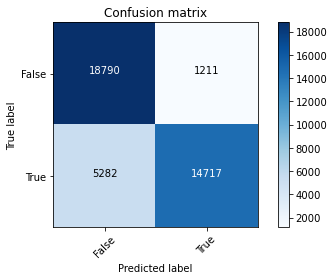

In [7]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
cnf_matrix = confusion_matrix(df_target_test, df_prediction)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=label_encoder.classes_)